In [1]:
import pandas as pd
import xgboost as xgb

import feather

from sklearn.cross_validation import KFold

In [2]:
df_train = feather.read_dataframe('feather/df_train_all.feather')
df_test = feather.read_dataframe('feather/df_test.feather')


In [3]:
del df_train['decision']

In [5]:
for c in df_train.columns:
    df_train[c] = df_train[c].astype('float32')
    df_test[c] = df_test[c].astype('float32')

In [7]:
df_train['target'] = 1.
df_test['target'] = 0.
df_all = pd.concat([df_train, df_test])

In [9]:
df_all.reset_index(drop=1, inplace=1)

In [10]:
df_all.target.value_counts()

1.0    2000000
0.0     750000
Name: target, dtype: int64

In [12]:
cv = KFold(len(df_all), n_folds=3, shuffle=True, random_state=1)

In [14]:
xgb_pars = {
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
# not deafauts
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 20,
    'seed': 42,
    'silent': 1
}

n_estimators = 100

In [18]:
features = sorted(set(df_all.columns) - {'target'})

In [19]:
X_full = df_all[features].values
y_full = df_all.target.values

In [25]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score

In [ ]:
train_preds = np.zeros(y_full.shape)

scores = []

for train, val in tqdm(cv):
    dtrain = xgb.DMatrix(X_full[train], label=y_full[train], feature_names=features, missing=np.nan)
    dval = xgb.DMatrix(X_full[val], label=y_full[val], feature_names=features, missing=np.nan)
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=5,
                      evals=watchlist)

    y_pred = model.predict(dval)
    train_preds[val] = y_pred
    score = roc_auc_score(y_full[val], y_pred)
    scores.append(score)

In [65]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('player.special_skill_used', 2235.7162562057138),
 ('opponent.special_skill_used', 1845.9879672292686),
 ('opponent.deck_count', 1155.7431976422886),
 ('turn', 1140.1942957190379),
 ('player.played.hp_current', 1078.0484058470586),
 ('player.crystals_all', 915.069278821138),
 ('player.hand.nOfPlayable', 784.2030781360463),
 ('player.crystals_current', 626.783337081081),
 ('opponent.crystals_current', 585.4238060676923),
 ('opponent.crystals_all', 555.7367442780752),
 ('opponent.hand_count', 490.52400165263157),
 ('player.hand.nOfCards', 441.8832821666667),
 ('player.hp', 390.76369087755086),
 ('opponent.weapon_durability', 377.76508105263156),
 ('opponent.played.hp_max', 368.4667901413045),
 ('opponent.hero_card_id', 321.2110454757993),
 ('player.played.hp_max', 292.5460261647059),
 ('player.attack', 263.5290734782609),
 ('player.played.crystals_cost', 242.07505540813926),
 ('player.hand.nOfMinions', 218.00604105769236),
 ('player.played.nOfCards', 216.8207041739131),
 ('opponent.hp'

In [28]:
df_all['pred'] = train_preds

In [77]:
df_train_pred = df_all[df_all['target'] == 1.0]

In [34]:
import seaborn as sns
%matplotlib inline

/home/agrigorev/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


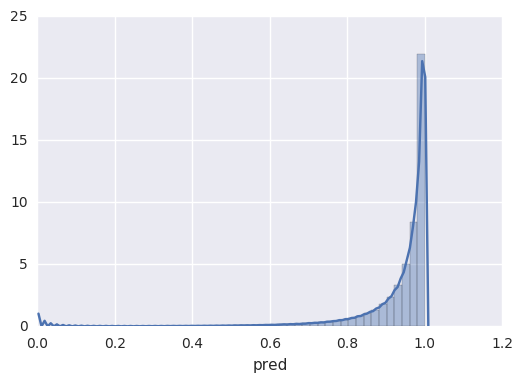

In [35]:
sns.distplot(df_train_pred.pred)

In [78]:
df_train_pred = df_train_pred.reset_index(drop=1)
#df_train_pred = df_train_pred.sort_values(by='pred')

In [56]:
len(df_train_pred) // 5

400000

In [61]:
sum(df_train_pred.pred <= 0.5)

18645

In [66]:
sum(df_train_pred.pred <= 0.6)

35386

In [62]:
sum(df_train_pred.pred <= 0.8)

145808

In [82]:
df_train = feather.read_dataframe('feather/df_train_all.feather')

In [83]:
df_train_val = df_train[df_train_pred.pred > 0.6].reset_index(drop=1)
df_val = df_train[df_train_pred.pred <= 0.6].reset_index(drop=1)

In [89]:
df_train_val.decision.value_counts(normalize=True)

1    0.502805
0    0.497195
Name: decision, dtype: float64

In [90]:
df_val.decision.value_counts(normalize=True)

1    0.615526
0    0.384474
Name: decision, dtype: float64

In [85]:
feather.write_dataframe(df_train_val, 'feather/df_train_m.feather')
feather.write_dataframe(df_val, 'feather/df_val_m.feather')